### Sabrina Nicacio
AA228 Final Project Code

### Simulating the Real World with Noise

In the first part of the project, we simulate a simplified **spacecraft rendezvous environment** so the decision-making and estimation algorithms can be tested in simulation.

We use the **Hill–Clohessy–Wiltshire (HCW) equations**, which describe the *relative motion* between a chaser spacecraft and a target in circular orbit. These equations model how the chaser moves in the **Local-Vertical Local-Horizontal (LVLH)** frame around the target, based on its position, velocity, and control thrust.

The model evolves in **discrete time**:
$$
x_{k+1} = A_d\, x_k + B_d\, u_k + w_k
$$
- $x_k = [x, y, z, \dot{x}, \dot{y}, \dot{z}]^\top$ is the true state (position and velocity).
- $u_k$ is the commanded acceleration or thrust input.
- $A_d, B_d$ come from discretizing the continuous HCW equations using matrix exponentials.
- $w_k \sim \mathcal{N}(0, Q_d)$ is **process noise**, modeling small unmodeled forces (e.g., drag, thrust errors, solar pressure).

To mimic real sensors, we also generate **noisy measurements**:
$$
y_k = H\, x_k + v_k
$$
where $v_k \sim \mathcal{N}(0, R)$ is **measurement noise** representing sensor uncertainty. In practice, this could correspond to small position errors from a vision system or radar during docking.

Together, this setup produces:
- The *true motion* of the spacecraft.
- The *noisy sensor data* the Kalman Filter will use to estimate the state.
- A realistic testbed where the decision-making algorithm can plan actions under uncertainty.

This is the part where we create the “real world” for the rest of the project, including realistic motion, noise, and uncertainty.


https://ensatellite.com/hills-equations/

### 1) Inputs/Parameters

In [16]:
import numpy as np
from scipy.linalg import expm, block_diag
import matplotlib.pyplot as plt

# PARAMETERS
dt = 2.0            # [s] time step (how often we apply control + get measurements)
N  = 800            # number of discrete time steps in the simulation
# total simulation time (just for intuition / sanity check)
T_total_sec  = N * dt          # [s] total simulated duration
T_total_min  = T_total_sec / 60.0  # [min] ~26.7 min for these choices
print(f"Total simulation time: {T_total_min:.2f} minutes")
n  = 0.0011         # [rad/s] mean motion (ω) - how fast the target moves around Earth (LEO-ish ~95 min period)

# Initial relative state in LVLH: [x,y,z,xd,yd,zd]
# Convention (must match HCW A matrix):
#   x : radial (outward from Earth through the target)
#   y : along-track (direction of target's velocity)
#   z : cross-track (completes right-handed frame)

scenario = "baseline"  # options: "baseline", "far_radial", "alongtrack_closing"

if scenario == "baseline":
    # 100 m radial, no relative velocity
    x0 = np.array([100.0, 0.0, 0.0,
                   0.0,   0.0, 0.0])

elif scenario == "far_radial":
    # farther start, still stationary
    x0 = np.array([500.0, 0.0, 0.0,
                   0.0,   0.0, 0.0])

elif scenario == "alongtrack_closing":
    # 200 m behind along-track with small closing velocity
    x0 = np.array([0.0, -200.0, 0.0,
                   0.0,   0.05, 0.0])

else:
    raise ValueError("Unknown scenario name")


# Noise levels (1-sigma) for process + measurements
# Process noise: unmodeled accelerations (thrust variability, J2, drag, etc.)
sigma_a = 2e-5   # [m/s^2]  accel disturbance per axis (process noise std)

# Measurement noise: how noisy my sensor is
sigma_p = 0.05   # [m]      position measurement noise (std per axis)
sigma_v = 0.01   # [m/s]    velocity measurement noise (std per axis, if used)

# For now, I'm assuming a sensor that only measures position (more realistic for vision/LiDAR)
use_pos_only = True

Total simulation time: 26.67 minutes


### 2) HCW continuous dynamics → discretized (Ad, Bd)

In [17]:
# Build the CW Matrices
def hcw_continuous_AB(n):
    A = np.zeros((6,6)) # State: x = [x, y, z, xdot, ydot, zdot]^T in LVLH
    B = np.zeros((6,3)) # Input: u = [ax, ay, az]^T specific acceleration in LVLH
    
    # kinematics (position derivatives)
    A[0,3] = 1.0 # row 0 column 3
    A[1,4] = 1.0
    A[2,5] = 1.0
    # HCW accelerations (dynamics)
    # ẍ - 2 n ẏ - 3 n^2 x = ax
    # ÿ + 2 n ẋ           = ay
    # z̈ +     n^2 z       = az
    # Written in first-order form, these give the rows for [vx, vy, vz]dot
    A[3, 0] = 3 * n**2   # 3 n^2 x term
    A[3, 4] = 2 * n      # + 2 n ydot term
    A[4, 3] = -2 * n     # - 2 n xdot term
    A[5, 2] = -n**2      # - n^2 z term
    # I’m modeling u = [ax, ay, az] as a direct specific acceleration in LVLH.
    # That means it directly appears in the acceleration states (vx_dot, vy_dot, vz_dot)
    B[3:, :] = np.eye(3)
    return A, B

# Continuous-to-discrete conversion using the Van Loan method.
# This gives me (Ad, Bd) for:
# x_{k+1} = Ad x_k + Bd u_k
# from the continuous system:
# xdot = A x + B u
def c2d_van_loan(A, B, dt):
    # Discretize using Van Loan
    # Build the augmented matrix:
    #   M = [ A  B ]
    #       [ 0  0 ]
    # and scale by dt. The matrix exponential of this block gives Ad and Bd
    M = np.block([
        [A, B],
        [np.zeros((3,6)), np.zeros((3,3))]
    ]) * dt
    E = expm(M)
    # Extract Ad and Bd from the top blocks:
    # E = [ Ad  Bd ]
    #     [ 0    I ]   (for this construction)
    Ad = E[:6,:6]
    Bd = E[:6,6:]
    return Ad, Bd

# Build the continuous-time HCW dynamics and convert them to discrete time.
# (Ad, Bd) define the discrete system:
# x_{k+1} = Ad x_k + Bd u_k + w_k
# These are the matrices the Kalman Filter will use in its prediction step.
A, B   = hcw_continuous_AB(n)
Ad, Bd = c2d_van_loan(A, B, dt)


### 3) Process noise Qd (accel white noise → pos/vel)

In [18]:
# Build the discrete-time process noise covariance Qd assuming
# white acceleration noise in each axis.
  
#    Idea:
#    If the true dynamics have small random accelerations w ~ N(0, sigma_a^2),
#    then position and velocity both get affected after discretization.
#    The mapping from accel noise → (pos, vel) noise is the standard
#    double-integrator covariance:
#        [ dt^3/3   dt^2/2 ]
#        [ dt^2/2   dt     ]  * sigma_a^2

def Qd_from_accel_white(dt, sigma_a):

    # 2x2 covariance for (pos, vel) driven by white accel noise in ONE axis
    Q1 = np.array([
        [dt**3/3, dt**2/2],
        [dt**2/2, dt     ]
    ]) * (sigma_a**2)

    # Build block-diagonal structure for x, y, z axes.
    # At this point the order is [x, xd, y, yd, z, zd]
    Q_block = block_diag(Q1, Q1, Q1)

    # Reorder rows/cols to match OUR state order: [x, y, z, xd, yd, zd]
    # This permutation swaps (pos, vel) pairs into the correct structure.
    perm = np.array([0, 2, 4,   1, 3, 5])
    Q6 = Q_block[np.ix_(perm, perm)]

    return Q6

# Final discrete-time process noise covariance (6x6)
Qd = Qd_from_accel_white(dt, sigma_a)

### 4) Measurement model (H, R) + input (u)

In [19]:
# Measurement model (H, R)

if use_pos_only:
    # Position-only measurements:
    # y_k = [x, y, z]^T + noise
    # H picks out just the position part from [x, y, z, xdot, ydot, zdot]^T
    H = np.hstack([np.eye(3), np.zeros((3, 3))])

    # Measurement noise covariance for position-only sensor
    # Each axis has variance sigma_p^2, no cross-correlation.
    R = (sigma_p**2) * np.eye(3)

else:
    # Full-state measurements:
    # y_k = [x, y, z, xdot, ydot, zdot]^T + noise
    H = np.eye(6)

    # Measurement noise covariance for position + velocity
    # First three entries for position, last three for velocity.
    R = np.diag([
        sigma_p**2, sigma_p**2, sigma_p**2,   # position variances
        sigma_v**2, sigma_v**2, sigma_v**2    # velocity variances
    ])



# Spacecraft mass + thrust levels (for control)

# I keep the dynamics in terms of acceleration u = [ax, ay, az],
# but here I explicitly define mass and thrust so the policy layer
# can think in terms of forces and fuel.
m = 500.0    # [kg] spacecraft mass (tunable)
T_main = 5.0 # [N]  main thruster level (CHANGE LATER BASED ON OUR SPECS)
T_rcs  = 0.2 # [N]  small RCS thruster level (CHANGE LATER BASED ON OUR SPECS)
# policy will later choose real thrust levels based on the mode (main vs RCS)

# Convert thrust [N] to specific acceleration [m/s^2]
a_main = T_main / m   # main thruster accel magnitude
a_rcs  = T_rcs  / m   # RCS accel magnitude



# Input sequence U (control accelerations)

# U[k, :] = [ax_k, ay_k, az_k] at each time step.
# For now, I just define a simple open-loop test input: main thruster
# firing along +x for the first 80 steps. The decision-making module
# will later decide when to use main vs RCS based on the belief state.
U = np.zeros((N, 3))

# Use main thruster along +x for the first ~160 s (80 * dt if dt = 2 s)
U[:80, 0] = a_main   # [m/s^2] along +x

# Later, the policy can switch between:
#   0      (no thrust)
#   ±a_rcs (fine control with RCS)
#   ±a_main (coarse maneuvers with main thruster)
# by just writing into U[k, :] before calling the environment step.



### 5) Simulator (truth + noisy measurements)

In [20]:
# generates true trajectory + noisy measurements

rng = np.random.default_rng(42)   # fixed seed for reproducibility

def simulate(Ad, Bd, Qd, H, R, x0, U):
    # Store full true trajectory (N+1 states because we include x0)
    X_true = np.zeros((N+1, 6))

    # Store all measurements y_k (size depends on H: 3 for pos-only, 6 for full-state)
    Y_meas = np.zeros((N, H.shape[0]))

    # Set initial true state
    X_true[0] = x0

    # Main simulation loop: propagate truth and generate measurements
    for k in range(N):

        # Process noise w_k ~ N(0, Qd)
        # This represents unmodeled forces (J2, drag, thrust errors, etc.)
        w = rng.multivariate_normal(np.zeros(6), Qd)

        # True dynamics:
        # x_{k+1} = Ad * x_k + Bd * u_k + w_k
        x_next = Ad @ X_true[k] + Bd @ U[k] + w

        # Measurement noise v_k ~ N(0, R)
        v = rng.multivariate_normal(np.zeros(H.shape[0]), R)

        # Measurement model:
        # y_k = H * x_{k+1} + v_k
        # (note: measurement of the NEW state)
        y = H @ x_next + v

        # Save results
        X_true[k+1] = x_next
        Y_meas[k]   = y

    return X_true, Y_meas


# Run the simulation and generate:
# - X_true: full true trajectory
# - Y_meas: noisy measurements we’ll feed into the Kalman filter
X_true, Y_meas = simulate(Ad, Bd, Qd, H, R, x0, U)


### 6) Plots

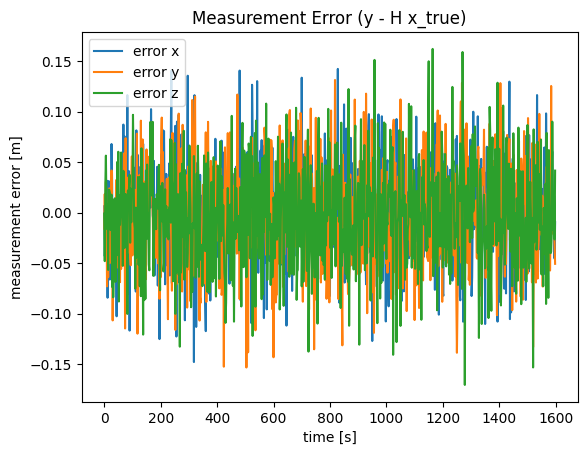

RMS error per axis (position):
x: 0.046908317849472546
y: 0.050443427194261314
z: 0.05015451370518453


In [23]:
# Plot measurement error: y_k - H x_{k+1}
t_meas = np.arange(N) * dt

# Project true state into measurement space so sizes match
X_true_meas = (H @ X_true[1:].T).T   # shape (N, meas_dim)

err = Y_meas - X_true_meas           # measurement error

plt.figure()
plt.plot(t_meas, err[:,0], label='error x')
plt.plot(t_meas, err[:,1], label='error y')
plt.plot(t_meas, err[:,2], label='error z')
plt.xlabel('time [s]')
plt.ylabel('measurement error [m]')
plt.title('Measurement Error (y - H x_true)')
plt.legend()
plt.show()


print("RMS error per axis (position):")
print("x:", np.sqrt(np.mean(err[:,0]**2)))
print("y:", np.sqrt(np.mean(err[:,1]**2)))
print("z:", np.sqrt(np.mean(err[:,2]**2)))



### Summary of the Simulation Results

The plots confirm that the simulation is working:

- The **true trajectory** follows the HCW dynamics with the applied input
- The **measurement error plot** shows zero-mean noise with RMS values ≈ $0.05$ m, matching the chosen $\sigma_p$
- This validates that the process noise $Q_d$ and measurement noise $R$ are behaving how we expect

### Main Outputs for the Kalman Filter

- Ad – discrete HCW state transition  
- Bd – discrete input (acceleration) matrix  
- Qd – process noise covariance  
- H – measurement matrix  
- R – measurement noise covariance  
- U – applied control inputs at each timestep  
- Y_meas – noisy measurements generated by sensor model
- x0 - initial state
- dt – simulation timestep (not a state, just needed for timing)

These fully define the linear-Gaussian system the KF will estimate.

### Connection to the POMDP

This simulation is also the “real world” environment for the POMDP:

- The KF will turn $(A_d, B_d, H, Q_d, R)$ and $Y_{\text{meas}}$ into a **belief state** (mean + covariance).
- The policy will use this belief to choose future thrust commands.